In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

In [174]:
#df_train = pd.read_csv("../data/sparse/train_new2.csv")
#df_test = pd.read_csv("../data/sparse/test_new2.csv")
df_train = pd.read_csv("../data/sparse/train_good.csv")
df_test = pd.read_csv("../data/sparse/test_good.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 269)

In [3]:
test_ids.shape

(48744,)

In [4]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

positive_data = None
negative_data = None


In [176]:
learning_rate = 0.1
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.05
num_boost_round = 10000
ncat = 43
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
          "categorical_feature" : range(ncat)
}

In [178]:
NFOLDS = 5
ncat = 43
#X = features_train_t.values
X_test = df_test.values

labels_train = df_labels.values
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))
x_score = []

best_trees = []
fold_scores = []
N = 16

oof_train_full = []
oof_test_full = [] 
for s in range(N):
    
    
    params['seed'] = s
    
    x_train , x_val , y_train , y_val = train_test_split( df_train , df_labels , test_size = 0.2 , random_state=s)

    positive_indx = y_train[ y_train == 1 ]
    positive_data = x_train.loc[ positive_indx.index.values  ]


    negative_indx = y_train[ y_train == 0 ]
    negative_data = x_train.loc[  negative_indx.index.values  ]
    negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s*5 )

    print(positive_data.shape)
    print(negative_data.shape )

    labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

    x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
    x_train_sampled["y"] = labels
    x_train_sampled = x_train_sampled.sample(frac = 1 ,random_state = s )
    labels_sampled = x_train_sampled["y"].values
    
    x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 ).values
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf = kfold.split( x_train_sampled , labels_sampled  )
    best_trees = []
    fold_scores = []
    
    cv_train = np.zeros( len( labels_sampled ))
    #cv_eval_total = np.zeros( len( y_val ) )
    
    cv_pred = np.zeros( len( test_ids ) )
    
    
    oof_train = np.zeros((  len( labels_train ) , ))
    oof_test = np.zeros((  len( test_ids )  , ))
    
    
    oof_test_skf = np.empty((NFOLDS, len( test_ids )  ))
    oof_train_skf = np.empty((NFOLDS, len( labels_train )  ))
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = x_train_sampled[train_fold, :], x_train_sampled[validate, :], labels_sampled[train_fold], labels_sampled[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train , categorical_feature = range(ncat)  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain , categorical_feature = range(ncat) )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
        #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  X_test , num_iteration = bst.best_iteration )
        #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )
                
        cv_train[validate] += bst.predict( X_validate )
        
        
        oof_train_skf[i, :] = bst.predict( df_train.values )
        oof_test_skf[ i , : ] = bst.predict( X_test )
        
    oof_test[:] = oof_test_skf.mean( axis = 0 )
    oof_train[:] = oof_train_skf.mean( axis = 0 )
    
    oof_train = oof_train.reshape(-1, 1)
    oof_test = oof_test.reshape( -1 , 1 )
    
    oof_train_full.append( oof_train ) 
    oof_test_full.append( oof_test )

    cv_pred /= NFOLDS
    final_cv_pred += cv_pred    

    print("cv score:")
    print( roc_auc_score( labels_sampled , cv_train )   )
    

    

(19970, 269)
(19850, 269)


/usr/local/lib/python2.7/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python2.7/dist-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.605962	valid_0's auc: 0.738561
[200]	valid_0's binary_logloss: 0.589234	valid_0's auc: 0.753709
[300]	valid_0's binary_logloss: 0.584283	valid_0's auc: 0.758082
[400]	valid_0's binary_logloss: 0.581995	valid_0's auc: 0.760293
[500]	valid_0's binary_logloss: 0.581451	valid_0's auc: 0.761069
[600]	valid_0's binary_logloss: 0.581957	valid_0's auc: 0.760892
Early stopping, best iteration is:
[505]	valid_0's binary_logloss: 0.581346	valid_0's auc: 0.761139
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.6071	valid_0's auc: 0.739302
[200]	valid_0's binary_logloss: 0.588971	valid_0's auc: 0.756256
[300]	valid_0's binary_logloss: 0.581867	valid_0's auc: 0.762211
[400]	valid_0's binary_logloss: 0.578142	valid_0's auc: 0.765301
[500]	valid_0's binary_logloss: 0.577241	valid_0's auc: 0.765784
Early stopping, best iteration is:
[453]	valid_0's binary_log

[200]	valid_0's binary_logloss: 0.583039	valid_0's auc: 0.765406
[300]	valid_0's binary_logloss: 0.574343	valid_0's auc: 0.771539
[400]	valid_0's binary_logloss: 0.573053	valid_0's auc: 0.771825
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.573382	valid_0's auc: 0.772066
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.599838	valid_0's auc: 0.75267
[200]	valid_0's binary_logloss: 0.58291	valid_0's auc: 0.765784
[300]	valid_0's binary_logloss: 0.57452	valid_0's auc: 0.771378
[400]	valid_0's binary_logloss: 0.573444	valid_0's auc: 0.771678
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.57376	valid_0's auc: 0.771863
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.604222	valid_0's auc: 0.743968
[200]	valid_0's binary_logloss: 0.588333	valid_0's auc: 0.757226
[300]	valid_0's binary_logloss: 0.58045	valid_0's auc: 0.763927
[400]	valid_0's binary_loglos

[400]	valid_0's binary_logloss: 0.571282	valid_0's auc: 0.772723
[500]	valid_0's binary_logloss: 0.571001	valid_0's auc: 0.77266
Early stopping, best iteration is:
[418]	valid_0's binary_logloss: 0.570967	valid_0's auc: 0.773056
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.608271	valid_0's auc: 0.740118
[200]	valid_0's binary_logloss: 0.592732	valid_0's auc: 0.753486
[300]	valid_0's binary_logloss: 0.585273	valid_0's auc: 0.760198
[400]	valid_0's binary_logloss: 0.582711	valid_0's auc: 0.762524
[500]	valid_0's binary_logloss: 0.582395	valid_0's auc: 0.76286
[600]	valid_0's binary_logloss: 0.582489	valid_0's auc: 0.762942
Early stopping, best iteration is:
[561]	valid_0's binary_logloss: 0.582022	valid_0's auc: 0.763356
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.604986	valid_0's auc: 0.743366
[200]	valid_0's binary_logloss: 0.588719	valid_0's auc: 0.756852
[300]	valid_0's binary_log

Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.568742	valid_0's auc: 0.776274
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.600605	valid_0's auc: 0.74956
[200]	valid_0's binary_logloss: 0.585503	valid_0's auc: 0.760474
[300]	valid_0's binary_logloss: 0.578763	valid_0's auc: 0.765547
[400]	valid_0's binary_logloss: 0.576803	valid_0's auc: 0.766721
[500]	valid_0's binary_logloss: 0.576044	valid_0's auc: 0.767137
Early stopping, best iteration is:
[466]	valid_0's binary_logloss: 0.575965	valid_0's auc: 0.767412
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.600512	valid_0's auc: 0.750608
[200]	valid_0's binary_logloss: 0.584893	valid_0's auc: 0.762147
[300]	valid_0's binary_logloss: 0.57829	valid_0's auc: 0.766675
[400]	valid_0's binary_logloss: 0.575864	valid_0's auc: 0.768594
Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.575624	valid_0's auc: 

[200]	valid_0's binary_logloss: 0.582034	valid_0's auc: 0.764253
[300]	valid_0's binary_logloss: 0.575897	valid_0's auc: 0.768942
[400]	valid_0's binary_logloss: 0.573763	valid_0's auc: 0.770694
[500]	valid_0's binary_logloss: 0.573049	valid_0's auc: 0.771002
[600]	valid_0's binary_logloss: 0.572984	valid_0's auc: 0.771137
Early stopping, best iteration is:
[555]	valid_0's binary_logloss: 0.572832	valid_0's auc: 0.771245
cv score:
0.7697162048117207
(19889, 269)
(19857, 269)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.594831	valid_0's auc: 0.755585
[200]	valid_0's binary_logloss: 0.583863	valid_0's auc: 0.762421
[300]	valid_0's binary_logloss: 0.58085	valid_0's auc: 0.763708
[400]	valid_0's binary_logloss: 0.578789	valid_0's auc: 0.765318
[500]	valid_0's binary_logloss: 0.578129	valid_0's auc: 0.766067
[600]	valid_0's binary_logloss: 0.57784	valid_0's auc: 0.7665
Early stopping, best iteration is:
[533]	valid_0's binary_logloss: 0.57

[500]	valid_0's binary_logloss: 0.580729	valid_0's auc: 0.762403
Early stopping, best iteration is:
[401]	valid_0's binary_logloss: 0.58063	valid_0's auc: 0.762613
cv score:
0.7689132482440398


In [181]:
new_train = np.hstack( oof_train_full )
new_test = np.hstack( oof_test_full )

In [182]:
final = final_cv_pred/16.0

In [145]:
new_train[:,0]

array([0.82669019, 0.1075067 , 0.25765525, ..., 0.37167225, 0.4791128 ,
       0.44050015])

In [21]:
new_test.shape

(48744, 16)

In [183]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "dart",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.01,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9
}

# Lightgbm model with oof_preds

In [184]:
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( test_ids ))

NFOLDS = 5 

M = 32 
x_score = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))
    
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.377866	valid_0's auc: 0.801263
[200]	valid_0's binary_logloss: 0.304333	valid_0's auc: 0.803434
[300]	valid_0's binary_logloss: 0.279653	valid_0's auc: 0.805306
[400]	valid_0's binary_logloss: 0.2641	valid_0's auc: 0.805818
[500]	valid_0's binary_logloss: 0.251555	valid_0's auc: 0.80615
[600]	valid_0's binary_logloss: 0.247543	valid_0's auc: 0.806475
[700]	valid_0's binary_logloss: 0.240484	valid_0's auc: 0.806775
[800]	valid_0's binary_logloss: 0.238284	valid_0's auc: 0.806865
[900]	valid_0's binary_logloss: 0.235611	valid_0's auc: 0.807113
[1000]	valid_0's binary_logloss: 0.23396	valid_0's auc: 0.807375
[1100]	valid_0's binary_logloss: 0.233552	valid_0's auc: 0.807537
[1200]	valid_0's binary_logloss: 0.233171	valid_0's auc: 0.807635
[1300]	valid_0's binary_logloss: 0.233137	valid_0's auc: 0.807721
Early stopping, best iteration is:
[1220]	valid_0's binary_logloss: 0.232957	valid_0's auc: 

[600]	valid_0's binary_logloss: 0.245044	valid_0's auc: 0.8089
[700]	valid_0's binary_logloss: 0.242101	valid_0's auc: 0.80908
[800]	valid_0's binary_logloss: 0.239597	valid_0's auc: 0.80916
[900]	valid_0's binary_logloss: 0.237136	valid_0's auc: 0.809371
[1000]	valid_0's binary_logloss: 0.236486	valid_0's auc: 0.809449
[1100]	valid_0's binary_logloss: 0.235001	valid_0's auc: 0.809533
[1200]	valid_0's binary_logloss: 0.233943	valid_0's auc: 0.809618
Early stopping, best iteration is:
[1197]	valid_0's binary_logloss: 0.233816	valid_0's auc: 0.809617
cv score - on train:
0.7922649210441692
('current score in fold:', 0.8020842398918464, 2)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.375905	valid_0's auc: 0.799728
[200]	valid_0's binary_logloss: 0.31486	valid_0's auc: 0.80223
[300]	valid_0's binary_logloss: 0.280832	valid_0's auc: 0.804092
[400]	valid_0's binary_logloss: 0.264639	valid_0's auc: 0.804533
[500]	valid_0's binary_logloss: 0.

[1400]	valid_0's binary_logloss: 0.232439	valid_0's auc: 0.80721
[1500]	valid_0's binary_logloss: 0.232029	valid_0's auc: 0.807241
[1600]	valid_0's binary_logloss: 0.231875	valid_0's auc: 0.807337
[1700]	valid_0's binary_logloss: 0.231891	valid_0's auc: 0.807424
[1800]	valid_0's binary_logloss: 0.231818	valid_0's auc: 0.807482
Early stopping, best iteration is:
[1735]	valid_0's binary_logloss: 0.23154	valid_0's auc: 0.807461
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.380658	valid_0's auc: 0.80486
[200]	valid_0's binary_logloss: 0.308514	valid_0's auc: 0.80571
[300]	valid_0's binary_logloss: 0.277765	valid_0's auc: 0.807727
[400]	valid_0's binary_logloss: 0.255714	valid_0's auc: 0.808604
[500]	valid_0's binary_logloss: 0.246316	valid_0's auc: 0.808781
[600]	valid_0's binary_logloss: 0.242468	valid_0's auc: 0.809231
[700]	valid_0's binary_logloss: 0.238636	valid_0's auc: 0.809483
[800]	valid_0's binary_logloss: 0.236778	valid_0's auc:

[500]	valid_0's binary_logloss: 0.250761	valid_0's auc: 0.809822
[600]	valid_0's binary_logloss: 0.244697	valid_0's auc: 0.810065
[700]	valid_0's binary_logloss: 0.239757	valid_0's auc: 0.810258
[800]	valid_0's binary_logloss: 0.2383	valid_0's auc: 0.810326
[900]	valid_0's binary_logloss: 0.236572	valid_0's auc: 0.810443
[1000]	valid_0's binary_logloss: 0.234058	valid_0's auc: 0.810762
[1100]	valid_0's binary_logloss: 0.232626	valid_0's auc: 0.81106
[1200]	valid_0's binary_logloss: 0.232441	valid_0's auc: 0.811356
Early stopping, best iteration is:
[1161]	valid_0's binary_logloss: 0.231805	valid_0's auc: 0.811337
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.385982	valid_0's auc: 0.80771
[200]	valid_0's binary_logloss: 0.311015	valid_0's auc: 0.809415
[300]	valid_0's binary_logloss: 0.27106	valid_0's auc: 0.811193
[400]	valid_0's binary_logloss: 0.258355	valid_0's auc: 0.811602
[500]	valid_0's binary_logloss: 0.250537	valid_0's auc: 0.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.385103	valid_0's auc: 0.80327
[200]	valid_0's binary_logloss: 0.311752	valid_0's auc: 0.806185
[300]	valid_0's binary_logloss: 0.276813	valid_0's auc: 0.808537
[400]	valid_0's binary_logloss: 0.264462	valid_0's auc: 0.808706
[500]	valid_0's binary_logloss: 0.250163	valid_0's auc: 0.808999
[600]	valid_0's binary_logloss: 0.243992	valid_0's auc: 0.809313
[700]	valid_0's binary_logloss: 0.240956	valid_0's auc: 0.809348
[800]	valid_0's binary_logloss: 0.239691	valid_0's auc: 0.809416
[900]	valid_0's binary_logloss: 0.23604	valid_0's auc: 0.809591
[1000]	valid_0's binary_logloss: 0.235532	valid_0's auc: 0.809647
[1100]	valid_0's binary_logloss: 0.233526	valid_0's auc: 0.809801
[1200]	valid_0's binary_logloss: 0.23214	valid_0's auc: 0.809932
[1300]	valid_0's binary_logloss: 0.231308	valid_0's auc: 0.810149
[1400]	valid_0's binary_logloss: 0.230991	valid_0's auc: 0.81033
[1500]	valid_0's binary_lo

[200]	valid_0's binary_logloss: 0.317664	valid_0's auc: 0.809305
[300]	valid_0's binary_logloss: 0.285649	valid_0's auc: 0.810044
[400]	valid_0's binary_logloss: 0.269152	valid_0's auc: 0.811283
[500]	valid_0's binary_logloss: 0.255287	valid_0's auc: 0.811764
[600]	valid_0's binary_logloss: 0.250121	valid_0's auc: 0.812125
[700]	valid_0's binary_logloss: 0.244302	valid_0's auc: 0.812222
[800]	valid_0's binary_logloss: 0.238936	valid_0's auc: 0.812911
[900]	valid_0's binary_logloss: 0.235627	valid_0's auc: 0.81312
[1000]	valid_0's binary_logloss: 0.234306	valid_0's auc: 0.813276
[1100]	valid_0's binary_logloss: 0.232687	valid_0's auc: 0.813547
[1200]	valid_0's binary_logloss: 0.232393	valid_0's auc: 0.813649
[1300]	valid_0's binary_logloss: 0.231579	valid_0's auc: 0.813831
Early stopping, best iteration is:
[1248]	valid_0's binary_logloss: 0.231436	valid_0's auc: 0.813733
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.384041	valid_0's au

[600]	valid_0's binary_logloss: 0.243013	valid_0's auc: 0.809312
[700]	valid_0's binary_logloss: 0.240384	valid_0's auc: 0.809429
[800]	valid_0's binary_logloss: 0.238106	valid_0's auc: 0.809566
[900]	valid_0's binary_logloss: 0.235457	valid_0's auc: 0.809687
[1000]	valid_0's binary_logloss: 0.234507	valid_0's auc: 0.809939
[1100]	valid_0's binary_logloss: 0.233096	valid_0's auc: 0.810175
[1200]	valid_0's binary_logloss: 0.232346	valid_0's auc: 0.810292
[1300]	valid_0's binary_logloss: 0.231935	valid_0's auc: 0.810365
[1400]	valid_0's binary_logloss: 0.231564	valid_0's auc: 0.810475
[1500]	valid_0's binary_logloss: 0.231187	valid_0's auc: 0.810583
[1600]	valid_0's binary_logloss: 0.230755	valid_0's auc: 0.810692
[1700]	valid_0's binary_logloss: 0.230598	valid_0's auc: 0.810748
[1800]	valid_0's binary_logloss: 0.230441	valid_0's auc: 0.810834
[1900]	valid_0's binary_logloss: 0.230223	valid_0's auc: 0.81094
Early stopping, best iteration is:
[1856]	valid_0's binary_logloss: 0.230118	vali

[700]	valid_0's binary_logloss: 0.240712	valid_0's auc: 0.807879
[800]	valid_0's binary_logloss: 0.238256	valid_0's auc: 0.808008
[900]	valid_0's binary_logloss: 0.236015	valid_0's auc: 0.808202
[1000]	valid_0's binary_logloss: 0.234544	valid_0's auc: 0.808307
[1100]	valid_0's binary_logloss: 0.233286	valid_0's auc: 0.808385
[1200]	valid_0's binary_logloss: 0.233317	valid_0's auc: 0.808542
[1300]	valid_0's binary_logloss: 0.232424	valid_0's auc: 0.808621
[1400]	valid_0's binary_logloss: 0.232562	valid_0's auc: 0.808702
Early stopping, best iteration is:
[1342]	valid_0's binary_logloss: 0.23207	valid_0's auc: 0.808674
cv score - on train:
0.8054755700992036
('current score in fold:', 0.8089682149155292, 11)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.391486	valid_0's auc: 0.801744
[200]	valid_0's binary_logloss: 0.309635	valid_0's auc: 0.805853
[300]	valid_0's binary_logloss: 0.283321	valid_0's auc: 0.807034
[400]	valid_0's binary_log

Early stopping, best iteration is:
[1412]	valid_0's binary_logloss: 0.232661	valid_0's auc: 0.807008
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.373138	valid_0's auc: 0.810479
[200]	valid_0's binary_logloss: 0.304326	valid_0's auc: 0.812828
[300]	valid_0's binary_logloss: 0.280319	valid_0's auc: 0.813563
[400]	valid_0's binary_logloss: 0.260266	valid_0's auc: 0.814301
[500]	valid_0's binary_logloss: 0.248865	valid_0's auc: 0.814436
[600]	valid_0's binary_logloss: 0.242805	valid_0's auc: 0.81471
[700]	valid_0's binary_logloss: 0.237595	valid_0's auc: 0.81484
[800]	valid_0's binary_logloss: 0.235849	valid_0's auc: 0.815007
[900]	valid_0's binary_logloss: 0.233886	valid_0's auc: 0.815113
[1000]	valid_0's binary_logloss: 0.23273	valid_0's auc: 0.815248
[1100]	valid_0's binary_logloss: 0.231471	valid_0's auc: 0.815415
[1200]	valid_0's binary_logloss: 0.230665	valid_0's auc: 0.815534
[1300]	valid_0's binary_logloss: 0.230159	valid_0's auc:

[1900]	valid_0's binary_logloss: 0.229747	valid_0's auc: 0.810623
[2000]	valid_0's binary_logloss: 0.229856	valid_0's auc: 0.810656
Early stopping, best iteration is:
[1903]	valid_0's binary_logloss: 0.229732	valid_0's auc: 0.810626
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.385779	valid_0's auc: 0.803664
[200]	valid_0's binary_logloss: 0.321782	valid_0's auc: 0.807221
[300]	valid_0's binary_logloss: 0.284962	valid_0's auc: 0.809263
[400]	valid_0's binary_logloss: 0.261765	valid_0's auc: 0.809689
[500]	valid_0's binary_logloss: 0.247856	valid_0's auc: 0.810352
[600]	valid_0's binary_logloss: 0.242353	valid_0's auc: 0.810512
Early stopping, best iteration is:
[594]	valid_0's binary_logloss: 0.243527	valid_0's auc: 0.810576
cv score - on train:
0.7863474088042445
('current score in fold:', 0.808904448827137, 14)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.367676	valid_0's auc: 0.805

[1900]	valid_0's binary_logloss: 0.229936	valid_0's auc: 0.812344
[2000]	valid_0's binary_logloss: 0.229569	valid_0's auc: 0.812446
[2100]	valid_0's binary_logloss: 0.22955	valid_0's auc: 0.812489
Early stopping, best iteration is:
[2027]	valid_0's binary_logloss: 0.229488	valid_0's auc: 0.812459
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.366997	valid_0's auc: 0.802914
[200]	valid_0's binary_logloss: 0.30035	valid_0's auc: 0.805595
[300]	valid_0's binary_logloss: 0.272292	valid_0's auc: 0.806857
[400]	valid_0's binary_logloss: 0.257125	valid_0's auc: 0.807166
[500]	valid_0's binary_logloss: 0.247638	valid_0's auc: 0.80741
[600]	valid_0's binary_logloss: 0.242374	valid_0's auc: 0.807681
[700]	valid_0's binary_logloss: 0.239646	valid_0's auc: 0.807831
[800]	valid_0's binary_logloss: 0.237749	valid_0's auc: 0.807924
[900]	valid_0's binary_logloss: 0.236748	valid_0's auc: 0.80794
[1000]	valid_0's binary_logloss: 0.236314	valid_0's auc: 

[1600]	valid_0's binary_logloss: 0.230165	valid_0's auc: 0.814424
[1700]	valid_0's binary_logloss: 0.22958	valid_0's auc: 0.814552
[1800]	valid_0's binary_logloss: 0.229258	valid_0's auc: 0.814689
[1900]	valid_0's binary_logloss: 0.229282	valid_0's auc: 0.814837
Early stopping, best iteration is:
[1847]	valid_0's binary_logloss: 0.229058	valid_0's auc: 0.814802
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.379097	valid_0's auc: 0.801166
[200]	valid_0's binary_logloss: 0.299577	valid_0's auc: 0.805043
[300]	valid_0's binary_logloss: 0.28078	valid_0's auc: 0.805908
[400]	valid_0's binary_logloss: 0.26038	valid_0's auc: 0.806953
[500]	valid_0's binary_logloss: 0.250701	valid_0's auc: 0.807199
[600]	valid_0's binary_logloss: 0.245061	valid_0's auc: 0.807225
Early stopping, best iteration is:
[531]	valid_0's binary_logloss: 0.248218	valid_0's auc: 0.80728
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_

[700]	valid_0's binary_logloss: 0.242154	valid_0's auc: 0.810105
[800]	valid_0's binary_logloss: 0.239365	valid_0's auc: 0.810494
[900]	valid_0's binary_logloss: 0.237446	valid_0's auc: 0.810597
[1000]	valid_0's binary_logloss: 0.236714	valid_0's auc: 0.810678
[1100]	valid_0's binary_logloss: 0.23442	valid_0's auc: 0.810789
[1200]	valid_0's binary_logloss: 0.233663	valid_0's auc: 0.811009
[1300]	valid_0's binary_logloss: 0.233291	valid_0's auc: 0.811089
[1400]	valid_0's binary_logloss: 0.232358	valid_0's auc: 0.811246
[1500]	valid_0's binary_logloss: 0.231431	valid_0's auc: 0.811434
[1600]	valid_0's binary_logloss: 0.23115	valid_0's auc: 0.811557
[1700]	valid_0's binary_logloss: 0.230678	valid_0's auc: 0.811677
[1800]	valid_0's binary_logloss: 0.230509	valid_0's auc: 0.811831
Early stopping, best iteration is:
[1761]	valid_0's binary_logloss: 0.23041	valid_0's auc: 0.811776
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.373658	valid_0's

[300]	valid_0's binary_logloss: 0.268889	valid_0's auc: 0.809508
[400]	valid_0's binary_logloss: 0.255204	valid_0's auc: 0.809597
[500]	valid_0's binary_logloss: 0.247799	valid_0's auc: 0.810256
[600]	valid_0's binary_logloss: 0.244435	valid_0's auc: 0.810362
[700]	valid_0's binary_logloss: 0.239647	valid_0's auc: 0.810444
[800]	valid_0's binary_logloss: 0.237184	valid_0's auc: 0.810797
[900]	valid_0's binary_logloss: 0.237013	valid_0's auc: 0.810849
Early stopping, best iteration is:
[827]	valid_0's binary_logloss: 0.236784	valid_0's auc: 0.810812
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.385065	valid_0's auc: 0.806157
[200]	valid_0's binary_logloss: 0.29879	valid_0's auc: 0.80976
[300]	valid_0's binary_logloss: 0.268971	valid_0's auc: 0.810763
[400]	valid_0's binary_logloss: 0.25527	valid_0's auc: 0.811017
[500]	valid_0's binary_logloss: 0.247845	valid_0's auc: 0.811174
[600]	valid_0's binary_logloss: 0.244449	valid_0's auc: 0.81

[1100]	valid_0's binary_logloss: 0.233436	valid_0's auc: 0.807589
[1200]	valid_0's binary_logloss: 0.232991	valid_0's auc: 0.807662
[1300]	valid_0's binary_logloss: 0.232752	valid_0's auc: 0.807748
[1400]	valid_0's binary_logloss: 0.232494	valid_0's auc: 0.807821
[1500]	valid_0's binary_logloss: 0.231895	valid_0's auc: 0.807951
[1600]	valid_0's binary_logloss: 0.231889	valid_0's auc: 0.807985
[1700]	valid_0's binary_logloss: 0.231867	valid_0's auc: 0.808045
Early stopping, best iteration is:
[1640]	valid_0's binary_logloss: 0.231772	valid_0's auc: 0.808014
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.396374	valid_0's auc: 0.803497
[200]	valid_0's binary_logloss: 0.309573	valid_0's auc: 0.805267
[300]	valid_0's binary_logloss: 0.274455	valid_0's auc: 0.808761
[400]	valid_0's binary_logloss: 0.256998	valid_0's auc: 0.809009
[500]	valid_0's binary_logloss: 0.249728	valid_0's auc: 0.809369
[600]	valid_0's binary_logloss: 0.243566	valid_0'

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.358853	valid_0's auc: 0.808935
[200]	valid_0's binary_logloss: 0.293558	valid_0's auc: 0.811394
[300]	valid_0's binary_logloss: 0.273673	valid_0's auc: 0.812052
[400]	valid_0's binary_logloss: 0.257442	valid_0's auc: 0.812272
[500]	valid_0's binary_logloss: 0.251334	valid_0's auc: 0.81248
[600]	valid_0's binary_logloss: 0.245734	valid_0's auc: 0.812614
[700]	valid_0's binary_logloss: 0.242224	valid_0's auc: 0.812769
[800]	valid_0's binary_logloss: 0.237704	valid_0's auc: 0.812861
[900]	valid_0's binary_logloss: 0.234966	valid_0's auc: 0.81313
[1000]	valid_0's binary_logloss: 0.233872	valid_0's auc: 0.813217
[1100]	valid_0's binary_logloss: 0.233221	valid_0's auc: 0.813329
[1200]	valid_0's binary_logloss: 0.232087	valid_0's auc: 0.81346
[1300]	valid_0's binary_logloss: 0.231751	valid_0's auc: 0.813547
[1400]	valid_0's binary_logloss: 0.230774	valid_0's auc: 0.813679
[1500]	valid_0's binary_l

[1700]	valid_0's binary_logloss: 0.231727	valid_0's auc: 0.810002
Early stopping, best iteration is:
[1689]	valid_0's binary_logloss: 0.23152	valid_0's auc: 0.809981
cv score - on train:
0.7968490304976077
('current score in fold:', 0.8092856421872019, 25)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.36444	valid_0's auc: 0.800612
[200]	valid_0's binary_logloss: 0.302738	valid_0's auc: 0.803366
[300]	valid_0's binary_logloss: 0.278432	valid_0's auc: 0.804685
[400]	valid_0's binary_logloss: 0.260854	valid_0's auc: 0.804664
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.267871	valid_0's auc: 0.80472
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.364345	valid_0's auc: 0.803103
[200]	valid_0's binary_logloss: 0.30263	valid_0's auc: 0.805264
[300]	valid_0's binary_logloss: 0.278292	valid_0's auc: 0.806792
[400]	valid_0's binary_logloss: 0.260673	valid_0's auc: 0.80689
[

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.373985	valid_0's auc: 0.804894
[200]	valid_0's binary_logloss: 0.303557	valid_0's auc: 0.80539
[300]	valid_0's binary_logloss: 0.270128	valid_0's auc: 0.807297
[400]	valid_0's binary_logloss: 0.258939	valid_0's auc: 0.807411
[500]	valid_0's binary_logloss: 0.247027	valid_0's auc: 0.807698
[600]	valid_0's binary_logloss: 0.242143	valid_0's auc: 0.807998
[700]	valid_0's binary_logloss: 0.240644	valid_0's auc: 0.808139
[800]	valid_0's binary_logloss: 0.238663	valid_0's auc: 0.808119
Early stopping, best iteration is:
[742]	valid_0's binary_logloss: 0.238481	valid_0's auc: 0.808144
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.374145	valid_0's auc: 0.801339
[200]	valid_0's binary_logloss: 0.303732	valid_0's auc: 0.805566
[300]	valid_0's binary_logloss: 0.2703	valid_0's auc: 0.807657
[400]	valid_0's binary_logloss: 0.259103	valid_0's auc: 0.8080

[800]	valid_0's binary_logloss: 0.236333	valid_0's auc: 0.81196
Early stopping, best iteration is:
[748]	valid_0's binary_logloss: 0.237469	valid_0's auc: 0.811968
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.377161	valid_0's auc: 0.79831
[200]	valid_0's binary_logloss: 0.309874	valid_0's auc: 0.802673
[300]	valid_0's binary_logloss: 0.27951	valid_0's auc: 0.803618
[400]	valid_0's binary_logloss: 0.267429	valid_0's auc: 0.803785
[500]	valid_0's binary_logloss: 0.253584	valid_0's auc: 0.803958
[600]	valid_0's binary_logloss: 0.243252	valid_0's auc: 0.804608
[700]	valid_0's binary_logloss: 0.240682	valid_0's auc: 0.804873
[800]	valid_0's binary_logloss: 0.238314	valid_0's auc: 0.804982
[900]	valid_0's binary_logloss: 0.237397	valid_0's auc: 0.805053
[1000]	valid_0's binary_logloss: 0.236043	valid_0's auc: 0.805207
[1100]	valid_0's binary_logloss: 0.234672	valid_0's auc: 0.805444
[1200]	valid_0's binary_logloss: 0.234045	valid_0's auc: 0

[1300]	valid_0's binary_logloss: 0.230813	valid_0's auc: 0.813762
[1400]	valid_0's binary_logloss: 0.230604	valid_0's auc: 0.813908
[1500]	valid_0's binary_logloss: 0.230092	valid_0's auc: 0.81401
[1600]	valid_0's binary_logloss: 0.22972	valid_0's auc: 0.814121
[1700]	valid_0's binary_logloss: 0.229212	valid_0's auc: 0.814246
[1800]	valid_0's binary_logloss: 0.228981	valid_0's auc: 0.814367
Early stopping, best iteration is:
[1793]	valid_0's binary_logloss: 0.228864	valid_0's auc: 0.814369
cv score - on train:
0.8106310520045874
('current score in fold:', 0.8093748733867522, 30)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.375131	valid_0's auc: 0.799691
[200]	valid_0's binary_logloss: 0.292301	valid_0's auc: 0.802668
[300]	valid_0's binary_logloss: 0.269051	valid_0's auc: 0.804475
[400]	valid_0's binary_logloss: 0.254742	valid_0's auc: 0.805207
[500]	valid_0's binary_logloss: 0.246297	valid_0's auc: 0.805253
[600]	valid_0's binary_log

[400]	valid_0's binary_logloss: 0.267257	valid_0's auc: 0.807229
[500]	valid_0's binary_logloss: 0.251754	valid_0's auc: 0.807252
[600]	valid_0's binary_logloss: 0.246028	valid_0's auc: 0.808088
[700]	valid_0's binary_logloss: 0.242261	valid_0's auc: 0.808232
[800]	valid_0's binary_logloss: 0.240109	valid_0's auc: 0.80829
[900]	valid_0's binary_logloss: 0.23764	valid_0's auc: 0.808425
[1000]	valid_0's binary_logloss: 0.235575	valid_0's auc: 0.808645
[1100]	valid_0's binary_logloss: 0.234495	valid_0's auc: 0.80877
[1200]	valid_0's binary_logloss: 0.233697	valid_0's auc: 0.8089
Early stopping, best iteration is:
[1171]	valid_0's binary_logloss: 0.233338	valid_0's auc: 0.808877
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.37181	valid_0's auc: 0.801444
[200]	valid_0's binary_logloss: 0.298684	valid_0's auc: 0.804462
[300]	valid_0's binary_logloss: 0.273588	valid_0's auc: 0.806629
[400]	valid_0's binary_logloss: 0.266526	valid_0's auc: 0.8

In [195]:
print( np.array(x_score).mean())
x_score

0.7987769984548989


[0.8034499487255756,
 0.7922649210441692,
 0.8037118935582123,
 0.8028072287622634,
 0.8099148464301225,
 0.7957325275998088,
 0.8104329385240773,
 0.7947093041055542,
 0.8098990459090402,
 0.8106626515505313,
 0.8054755700992036,
 0.7877350738259302,
 0.8102617486139418,
 0.7863474088042445,
 0.8064907774826636,
 0.8108442207456327,
 0.8005212320918111,
 0.7876745094366978,
 0.750899955476026,
 0.8024170939855985,
 0.8077684367751766,
 0.7969797519762924,
 0.8001050767497597,
 0.8001182690726727,
 0.7968490304976077,
 0.789256754506167,
 0.7833206751613117,
 0.8084362762938483,
 0.8017240973635453,
 0.8106310520045874,
 0.7895970638415906,
 0.793824569543101]

In [191]:
final_pred_lgb = final_cv_pred/32.0

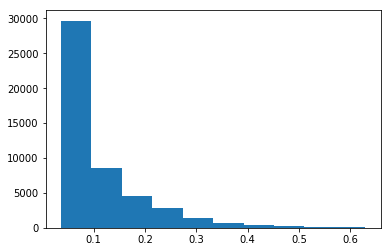

In [192]:
plt.hist( final_pred_lgb)
plt.show()

# XGboost model with oof_preds

In [219]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 5000
params = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [ ]:
final_cv_train_xgbst = np.zeros(len(labels_train))
final_cv_pred_xgbst = np.zeros(len( test_ids ))

NFOLDS = 5 

M = 32 
x_score_xgbst = []
dtest = xgb.DMatrix( new_test )
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]

        dtrain = xgb.DMatrix( X_train , label=label_train )
        dvalid = xgb.DMatrix( X_validate , label = label_validate )
        evallist = [ (dvalid, 'eval') ]
        bst = xgb.train(params, dtrain, num_boost_round, evallist  , early_stopping_rounds=100 , verbose_eval=100 )
        #bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        #cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
        
        cv_pred += bst.predict( dtest, ntree_limit=bst.best_ntree_limit )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( dvalid , ntree_limit=bst.best_ntree_limit )
    
    cv_pred /= NFOLDS
    
    final_cv_train_xgbst += cv_train
    final_cv_pred_xgbst += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train_xgbst / (s + 1.)), s+1)
    
    x_score_xgbst.append(roc_auc_score( labels_train , cv_train))

[0]	eval-auc:0.770092
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.801389
[200]	eval-auc:0.805189
[300]	eval-auc:0.806782
[400]	eval-auc:0.807197
[500]	eval-auc:0.807641
[600]	eval-auc:0.807878
[700]	eval-auc:0.807975
[800]	eval-auc:0.808022
[900]	eval-auc:0.808076
[1000]	eval-auc:0.808163
[1100]	eval-auc:0.808198
[1200]	eval-auc:0.808281
[1300]	eval-auc:0.808447
[1400]	eval-auc:0.808528
[1500]	eval-auc:0.808578
[1600]	eval-auc:0.808586
Stopping. Best iteration:
[1582]	eval-auc:0.808602

[0]	eval-auc:0.776482
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805602
[200]	eval-auc:0.808829
[300]	eval-auc:0.809492
[400]	eval-auc:0.810059
[500]	eval-auc:0.810274
[600]	eval-auc:0.810493
[700]	eval-auc:0.810617
[800]	eval-auc:0.810672
[900]	eval-auc:0.810712
[1000]	eval-auc:0.810723
[1100]	eval-auc:0.810806
[1200]	eval-auc:0.810852
[1300]	eval-auc:0.810838
Stopping. Best iteration:
[1232]	eval-auc:0.810857

[0]	eval-auc:0.77627
Will train

[800]	eval-auc:0.811959
[900]	eval-auc:0.812014
[1000]	eval-auc:0.812092
[1100]	eval-auc:0.812121
[1200]	eval-auc:0.812192
[1300]	eval-auc:0.812209
[1400]	eval-auc:0.812267
[1500]	eval-auc:0.812343
[1600]	eval-auc:0.812373
[1700]	eval-auc:0.812416
[1800]	eval-auc:0.812424
Stopping. Best iteration:
[1794]	eval-auc:0.812429

[0]	eval-auc:0.774159
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808837
[200]	eval-auc:0.812703
[300]	eval-auc:0.81393
[400]	eval-auc:0.814346
[500]	eval-auc:0.814869
[600]	eval-auc:0.815095
[700]	eval-auc:0.815287
[800]	eval-auc:0.815351
[900]	eval-auc:0.81551
[1000]	eval-auc:0.815599
Stopping. Best iteration:
[994]	eval-auc:0.815605

[0]	eval-auc:0.776046
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804621
[200]	eval-auc:0.808338
[300]	eval-auc:0.809269
[400]	eval-auc:0.80978
[500]	eval-auc:0.810152
[600]	eval-auc:0.810406
[700]	eval-auc:0.810514
[800]	eval-auc:0.810563
[900]	eval-auc:0.810612
[1000]	eval-

[3000]	eval-auc:0.809541
[3100]	eval-auc:0.809566
[3200]	eval-auc:0.809597
[3300]	eval-auc:0.809614
[3400]	eval-auc:0.809625
[3500]	eval-auc:0.80964
[3600]	eval-auc:0.80966
[3700]	eval-auc:0.809668
[3800]	eval-auc:0.809678
[3900]	eval-auc:0.80968
Stopping. Best iteration:
[3827]	eval-auc:0.809691

[0]	eval-auc:0.777423
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805645
[200]	eval-auc:0.808736
[300]	eval-auc:0.810928
[400]	eval-auc:0.811289
[500]	eval-auc:0.811709
[600]	eval-auc:0.811854
[700]	eval-auc:0.812016
[800]	eval-auc:0.812123
[900]	eval-auc:0.812205
[1000]	eval-auc:0.812277
[1100]	eval-auc:0.81232
[1200]	eval-auc:0.812389
[1300]	eval-auc:0.812501
[1400]	eval-auc:0.812671
[1500]	eval-auc:0.812762
[1600]	eval-auc:0.812828
[1700]	eval-auc:0.812907
[1800]	eval-auc:0.812944
[1900]	eval-auc:0.812979
[2000]	eval-auc:0.812992
Stopping. Best iteration:
[1942]	eval-auc:0.812993

[0]	eval-auc:0.774375
Will train until eval-auc hasn't improved in 100 rounds.
[

Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.800825
[200]	eval-auc:0.80443
[300]	eval-auc:0.805542
[400]	eval-auc:0.805962
[500]	eval-auc:0.806331
[600]	eval-auc:0.806409
[700]	eval-auc:0.806473
[800]	eval-auc:0.806467
Stopping. Best iteration:
[709]	eval-auc:0.80648

[0]	eval-auc:0.771167
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.801138
[200]	eval-auc:0.805253
[300]	eval-auc:0.80635
[400]	eval-auc:0.807005
[500]	eval-auc:0.807439
[600]	eval-auc:0.807605
[700]	eval-auc:0.807777
[800]	eval-auc:0.807826
[900]	eval-auc:0.807883
[1000]	eval-auc:0.808017
[1100]	eval-auc:0.808067
[1200]	eval-auc:0.808136
[1300]	eval-auc:0.808231
[1400]	eval-auc:0.808331
[1500]	eval-auc:0.808377
[1600]	eval-auc:0.808397
[1700]	eval-auc:0.808432
[1800]	eval-auc:0.808452
[1900]	eval-auc:0.808479
[2000]	eval-auc:0.808471
Stopping. Best iteration:
[1910]	eval-auc:0.808487

cv score - on train:
0.811311920330593
('current score in fold:', 0.8115717518579

[1000]	eval-auc:0.80987
[1100]	eval-auc:0.809943
[1200]	eval-auc:0.810001
[1300]	eval-auc:0.810154
[1400]	eval-auc:0.810271
[1500]	eval-auc:0.810394
[1600]	eval-auc:0.810446
[1700]	eval-auc:0.810452
Stopping. Best iteration:
[1625]	eval-auc:0.810459

[0]	eval-auc:0.77568
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806057
[200]	eval-auc:0.809921
[300]	eval-auc:0.810656
[400]	eval-auc:0.811088
[500]	eval-auc:0.811263
[600]	eval-auc:0.811434
[700]	eval-auc:0.811497
[800]	eval-auc:0.811564
[900]	eval-auc:0.811607
[1000]	eval-auc:0.811622
Stopping. Best iteration:
[971]	eval-auc:0.811649

[0]	eval-auc:0.777663
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805238
[200]	eval-auc:0.809315
[300]	eval-auc:0.810749
[400]	eval-auc:0.811243
[500]	eval-auc:0.811737
[600]	eval-auc:0.811928
[700]	eval-auc:0.811993
[800]	eval-auc:0.812065
[900]	eval-auc:0.81212
Stopping. Best iteration:
[893]	eval-auc:0.812123

cv score - on train:
0.81085249121

[1100]	eval-auc:0.80479
[1200]	eval-auc:0.804902
[1300]	eval-auc:0.804968
[1400]	eval-auc:0.805054
[1500]	eval-auc:0.805119
[1600]	eval-auc:0.805153
[1700]	eval-auc:0.805169
[1800]	eval-auc:0.805223
[1900]	eval-auc:0.805262
[2000]	eval-auc:0.805296
[2100]	eval-auc:0.805307
[2200]	eval-auc:0.805329
Stopping. Best iteration:
[2180]	eval-auc:0.805336

[0]	eval-auc:0.778488
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806372
[200]	eval-auc:0.809049
[300]	eval-auc:0.810217
[400]	eval-auc:0.810693
[500]	eval-auc:0.811062
[600]	eval-auc:0.811258
[700]	eval-auc:0.811448
[800]	eval-auc:0.8115
[900]	eval-auc:0.811593
[1000]	eval-auc:0.811628
[1100]	eval-auc:0.81165
[1200]	eval-auc:0.811717
[1300]	eval-auc:0.81185
[1400]	eval-auc:0.811973
[1500]	eval-auc:0.812037
[1600]	eval-auc:0.812101
[1700]	eval-auc:0.812131
[1800]	eval-auc:0.812167
[1900]	eval-auc:0.812195
[2000]	eval-auc:0.812233
[2100]	eval-auc:0.812237
[2200]	eval-auc:0.812248
[2300]	eval-auc:0.812259
[2400]	e

[100]	eval-auc:0.805432
[200]	eval-auc:0.809973
[300]	eval-auc:0.810663
[400]	eval-auc:0.811057
[500]	eval-auc:0.811465
[600]	eval-auc:0.811784
[700]	eval-auc:0.811859
[800]	eval-auc:0.811976
[900]	eval-auc:0.812025
[1000]	eval-auc:0.812134
[1100]	eval-auc:0.81219
[1200]	eval-auc:0.8122
[1300]	eval-auc:0.812396
[1400]	eval-auc:0.812526
[1500]	eval-auc:0.812614
[1600]	eval-auc:0.81265
[1700]	eval-auc:0.812682
[1800]	eval-auc:0.812683
[1900]	eval-auc:0.812706
[2000]	eval-auc:0.812701
Stopping. Best iteration:
[1931]	eval-auc:0.812717

[0]	eval-auc:0.774087
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.803521
[200]	eval-auc:0.806731
[300]	eval-auc:0.807905
[400]	eval-auc:0.808764
[500]	eval-auc:0.80899
[600]	eval-auc:0.809183
[700]	eval-auc:0.809308
[800]	eval-auc:0.809428
[900]	eval-auc:0.809482
[1000]	eval-auc:0.80951
[1100]	eval-auc:0.809581
[1200]	eval-auc:0.809635
[1300]	eval-auc:0.809739
[1400]	eval-auc:0.809836
[1500]	eval-auc:0.8099
[1600]	eval-auc:0.80

[100]	eval-auc:0.796902
[200]	eval-auc:0.801863
[300]	eval-auc:0.802918
[400]	eval-auc:0.803491
[500]	eval-auc:0.803835
[600]	eval-auc:0.804025
[700]	eval-auc:0.804208
[800]	eval-auc:0.80427
[900]	eval-auc:0.804328
[1000]	eval-auc:0.804342
[1100]	eval-auc:0.804369
[1200]	eval-auc:0.804411
[1300]	eval-auc:0.804467
[1400]	eval-auc:0.804479
Stopping. Best iteration:
[1391]	eval-auc:0.804483

cv score - on train:
0.8108349275033553
('current score in fold:', 0.8116118995993826, 20)
[0]	eval-auc:0.773334
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.801025
[200]	eval-auc:0.804089
[300]	eval-auc:0.805311
[400]	eval-auc:0.805988


In [ ]:
np.array( x_score_xgbst).mean()

In [201]:
final_xgb = final_cv_pred_xgbst/32.0

In [200]:
final_xgb

array([0.07206896, 0.16173474, 0.03109069, ..., 0.01995817, 0.04282659,
       0.18700212])

In [80]:
final = final_cv_pred/32

In [213]:
final_train = final_cv_train_xgbst/32.0
final_train_lgb = final_cv_train/32.0

In [214]:
final_pos = final_train[ labels_train == 1  ]
final_neg = final_train[labels_train == 0 ]
final_pos_lgb = final_train_lgb[ labels_train == 1  ]
final_neg_lgb = final_train_lgb[labels_train == 0 ]

In [207]:
print( np.array( x_score).mean() )

0.7987769984548989


In [208]:
roc_auc_score( labels_train , final_cv_train/32 ) 

0.8094073211474969

In [209]:
a = len(final_pos)

In [210]:
b = len(final_neg)

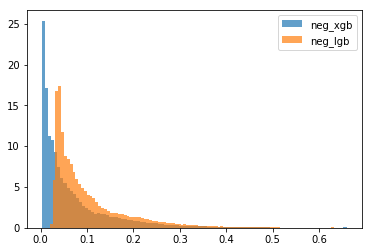

In [218]:
#plt.hist( final_pos , density = True , bins = 100 , label = "pos_xgb" )
plt.hist(  final_neg  , density = True , bins = 100 , alpha = 0.7 , label = "neg_xgb")
#plt.hist( final_pos_lgb , density = True , bins = 100 , label = "pos_lgb" )
plt.hist(  final_neg_lgb , density = True , bins = 100 , alpha = 0.7 , label = "neg_lgb")

plt.legend()
plt.show()

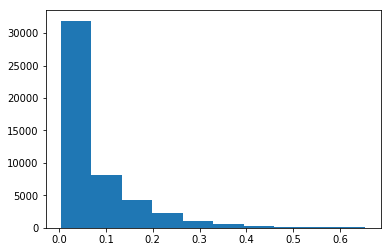

In [202]:
plt.hist( final_xgb)
plt.show()

In [111]:
final_logi.shape

(307511,)

In [203]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_pred_lgb }).to_csv('../data/pred_xgb_oof.csv', index=False)

Plot feature importances...


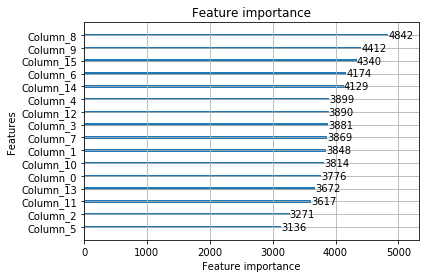

In [48]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=20)
plt.show()